Amogh Joshi: 23537673

Blaise Appolinary: 61731634

Derrick Cheng: 94068467

Michael Hoefert: 80784226

<span style="color:blue; font-size:18px; font-weight:bold">Part 1: Introduction</span>

<span style="font-weight:bold; color:black; font-size:16px">Title:</span> <span style = "color:black; font-size:16px">How well can we predict credit card default from age and education in Taiwan? </span>

<span style="font-weight:bold; color:black; font-size:16px">Introduction: </span> <span style = "color:black; font-size:16px"> The data set we are using is an aggregate of credit card data from various individuals in Taiwan that includes variables such as education, age, whether or not they defaulted on a payment and others. Default on payment means that an individual did not pay their credit card bills. Our question for this data analytics project is: </span>
<ul> <li><span style = "color:black; font-size:16px"> How accurately can Education, and Age predict the likelihood of an individual defaulting on their next credit card payment? </span></li> </ul>

<span style = "color:black; font-size:16px"> Why did we choose these predictor variables over the numerous other variables in the data set? Our first objective was to eliminate those variables we felt did not contribute at all to the probability of default payments, such as sex. Next, we did some external research and found that of the remaining variables that we had access to in the dataset, age and education matched the best predictors of default probability from our external research (T. M. Alam et al., 2020). Thus, we will build our classification model on these two predictor models to determine the accuracy to which we can predict default probability. </span>

<span style = "color:black; font-size:16px"> The dataset we will be using has 25 variables and 30002 records. The data set includes the variables we mentioned above and others such as the bill amounts each client has as well as the payments each client has made towards those bill amounts. Education is classified with numbers 1 (Graduate School), 2 (University), 3 (High School), and 4 (Others). Age is simply the numeric value of the individual's age. The default payment variable is represented by 1’s (Yes, did default) and 0’s (No, did not default). </span>

<span style = "color:black; font-size:16px"> We are interested in this question since credit card default is a real problem in the world, with credit card delinquency rates increasing by 0.180%  year on year from 2017 to 2018, in Taiwan (CEIC, 2018). Using the models we create, we can determine the risk of lending credit to an individual with a high risk of default and therefore protect the creditors. </span>

<span style="font-weight:bold; color:black; font-size:16px">Methods: </span> <span style = "color:black; font-size:16px"> We will be including the following columns: Education, Age and Default payment next month. We will conduct our data analysis using classification. Our classification will be done by creating a test set and a training set. Following this, we will begin to create a model that will tune the K nearest neighbors value we should use and a recipe that uses the straight line (“rectangular”) method to predict classifications. Following this we will fold the training set (most likely 10 times) to allow for a relatively accurate prediction of the K nearest neighbors value we should use. Using this, we will move forward with applying our model to our test set and predicting the classifications. </span>

<span style = "color:black; font-size:16px"> We will create a bar chart that will depict the proportion of how many classifications were correctly predicted next to another bar that depicts the proportion of classifications that were incorrectly predicted. </span>

<span style="font-weight:bold; color:black; font-size:16px">Expected outcomes and significance: </span> <span style = "color:black; font-size:16px"> We expect to find that there is a correlation between the variables education, age and the classification of whether the individual defaulted. We expect to find that we will be able to get a fairly accurate accuracy. We define fairly accurate as an accuracy above 70%.  Findings like this can allow credit card companies to apply higher late/default rates to customers who are more likely to default on payments based on our model and classification. Future questions would be: </span>

<ul>
 <li> <span style = "color:black; font-size:16px"> How can we make our predictions more accurate? </span></li>
<li> <span style = "color:black; font-size:16px"> Is it ethical to change rates/interest on individuals who have been classified by a model to be more likely to default? </span></li>
 </ul>





In [15]:
install.packages("skimr")
library(tidyverse)
library(repr)
library(tidymodels)
library(readxl)
library(ggplot2)
library(skimr)
options(repr.plot.width=10, repr.plot.height=6, repr.matrix.max.rows = 6)



Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done




<span style="color:blue; font-size:18px; font-weight:bold"> Part 2: Methods & Results</span>

<span style = "color:black; font-size:16px"> Firstly, we downloaded the excel file to a temporary address from the Machine Learning Repository from the University of California, Irvine, through tempfile and download.file commands. Since the data was in .xls file, we could not directly enter the URL where the file was located since the read_excel command cannot directly read from an URL. As such, we need to download the file to a temporary address and read it from said address. </span>


In [2]:
set.seed(1234)
temporary <- tempfile()
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls", temporary)
credit_card <- read_excel(temporary, skip = 1)
colnames(credit_card)[25] <- "default_payment_next_month"
credit_card

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,⋯,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default_payment_next_month
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,20000,2,2,1,24,2,2,-1,-1,⋯,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,⋯,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,⋯,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
29998,30000,1,2,2,37,4,3,2,-1,⋯,20878,20582,19357,0,0,22000,4200,2000,3100,1
29999,80000,1,3,1,41,1,-1,0,0,⋯,52774,11855,48944,85900,3409,1178,1926,52964,1804,1
30000,50000,1,2,1,46,0,0,0,0,⋯,36535,32428,15313,2078,1800,1430,1000,1000,1000,1


Table 1: Inital uncleaned dataset. There are are extra columns for bill amounts and payment amounts which we are not interested in.

<span style = "color:black; font-size:16px"> Once we read the file into our Jupyter Notebook we made sure that the data was clean. To make sure it was clean we double checked that there were no N/A values, there were none. We identified our variable that would be our classifier for our prediction and converted it into a factor to ensure we would be able to classify it. The next step was to split the large data set into our training and test set. We did this because we want to make sure that we do not use the testing dataset at all until the very end once we have created our models, recipes and found the most accurate K nearest neighbors value. We split the data sets as 75% training and 25% training. We set the strata equal to our classification variable, “default_payment_next_month”. Next, we finalized the split of the data into two different data sets; credit_train and credit_test. </span>

In [3]:
tidied_credit_card <- credit_card %>% 
                    select(EDUCATION, AGE, default_payment_next_month) %>%
                    mutate(default_payment_next_month = as_factor(default_payment_next_month)) %>%
                    filter(EDUCATION == c(1,2,3,4))
credit_split <- initial_split(tidied_credit_card, prop = 0.75, strata = default_payment_next_month)
credit_train <- training(credit_split)
credit_test <- testing(credit_split)
credit_train



EDUCATION,AGE,default_payment_next_month
<dbl>,<dbl>,<fct>
2,26,1
3,34,0
2,30,1
⋮,⋮,⋮
2,44,0
2,37,1
3,41,1


Table 2: Cleaned dataset containing only columns which will be used for both data analysis, and model fitting.

<span style="font-weight:bold; color:black; font-size:16px"> Statistics Summary: </span> <span style = "color:black; font-size:16px"> After running a statistics summary we gathered insightful information about our database. From the statistics summary we can find that the mean age is 35.5 and the mean education level is 1.81. We also see the standard deviations which were 9.25 for age and 0.708 for education level. Based on the mean and sd values we can see that 68% of the ages are between the ranges 26.25  and 44.75 while 68% of the education levels are in the ranges 1.102 and 2.518. This indicated that the majority of our data set are individuals with education levels 1 and 2. Lastly, we noticed that our default and non-default count were not equal, as such our data was not balanced. However, because we used the vfold function, this ended up balancing the data in the end. </span>

<span style = "color:black; font-size:16px">


</span>

In [4]:
skim(credit_train)

── Data Summary ────────────────────────
                           Values      
Name                       credit_train
Number of rows             5524        
Number of columns          3           
_______________________                
Column type frequency:                 
  factor                   1           
  numeric                  2           
________________________               
Group variables            None        

── Variable type: factor ───────────────────────────────────────────────────────
  skim_variable              n_missing complete_rate ordered n_unique
1 default_payment_next_month         0             1 FALSE          2
  top_counts      
1 0: 4306, 1: 1218

── Variable type: numeric ──────────────────────────────────────────────────────
  skim_variable n_missing complete_rate  mean    sd    p0   p25   p50   p75
1 EDUCATION             0             1  1.81 0.708     1     1     2     2
2 AGE                   0             1 35.5  9.25     21    28  

Table 3: Summary Table of all the variables which will be used in the training data set.

<span style = "color:black; font-size:16px"> In order to get a sense for the training dataset and to understand it more thoroughly, we did some preliminary data analysis. We firstly noticed that the dataset had more choices for education than what was stated on the website, so rather than there just being 4 choices, there were 6. Therefore, since we did not know what the extra choices referred to (and with the help of a TA who advised us to do the same), we filtered out said choices. The impact of this filtering was very minor since it only affected about 20 data samples. </span>


In [5]:
set.seed(1234)
credit_summarize <- credit_train %>%
                    group_by(EDUCATION, AGE, default_payment_next_month) %>%
                    summarize(n = n()) 
credit_summarize

`summarise()` regrouping output by 'EDUCATION', 'AGE' (override with `.groups` argument)



EDUCATION,AGE,default_payment_next_month,n
<dbl>,<dbl>,<fct>,<int>
1,21,0,3
1,22,0,16
1,22,1,6
⋮,⋮,⋮,⋮
4,48,0,1
4,49,0,1
4,50,0,1


Table 4: Grouped the training data set by education, age, and default payment next month. Summarized the grouped data set.

<span style = "color:black; font-size:16px"> Next, we graphed the filtered data to understand how the data was balanced. We wanted to see if there was an obvious correlation between the variables, and as such, grouped the observations and graphed them using a barchart. We did separate graphs for education and age in order to isolate so we can gain a better understanding of how the variable impacts risk of credit default. </span>

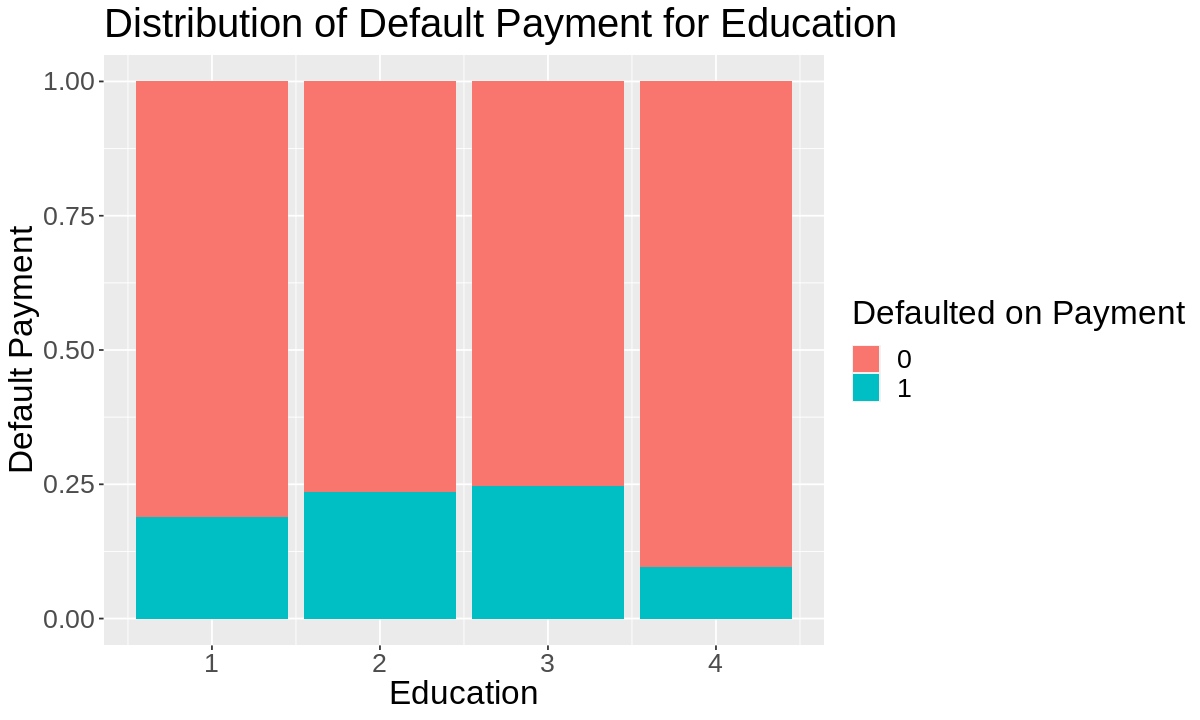

In [6]:
set.seed(1234)
credit_education_graph <- ggplot(credit_summarize, aes(x = EDUCATION, y = n, fill = default_payment_next_month)) +
                geom_bar(stat = "identity", position = "fill") +
                labs(x = "Education", y = "Default Payment", title = "Distribution of Default Payment for Education", fill = "Defaulted on Payment") +
                theme(text = element_text(size=20))
credit_education_graph

Figure 1: Distrubution of Default Payment for Education. This graph shows the distribution between each education level and the number of default payments 1 (Yes) and 0 (No) in the training data set. The graph shows that Education levels 2 and 3 have the highest default rate. 

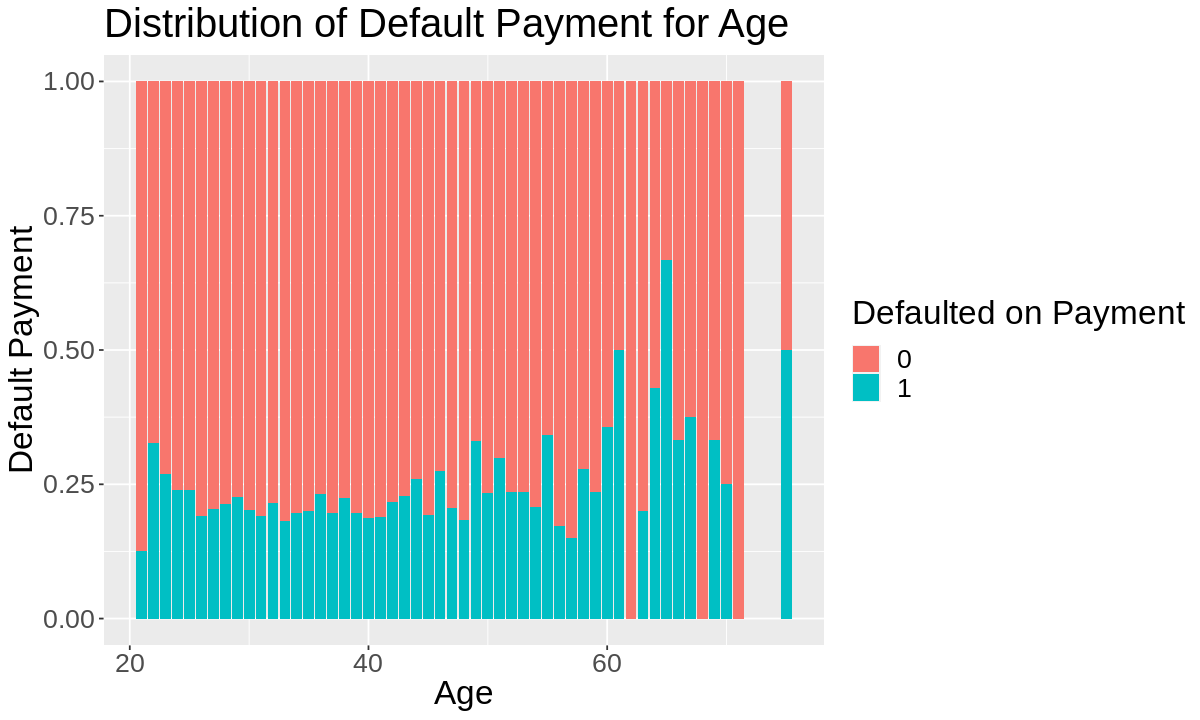

In [7]:
set.seed(1234)
credit_sex_graph <- ggplot(credit_summarize, aes(x = AGE, y = n, fill = default_payment_next_month)) +
                geom_bar(stat = "identity", position = "fill") +
                labs(x = "Age", y = "Default Payment", title = "Distribution of Default Payment for Age", fill = "Defaulted on Payment") +
                theme(text = element_text(size=20))
credit_sex_graph

Figure 2: Distrubution of Default Payment for Age. This graph shows the distribution between each age and the number of default payments 1 (Yes) and 0 (No) in the training data set. The graph shows that older ages around 60+ have a higher rate of default payment, which could be attributed to smaller amounts of data points from the age range. 

<span style = "color:black; font-size:16px"> The next step of our analysis was building our recipe, model and workflow. For our model we used the rectangular method of prediction and tuned our neighbors function. We used tune instead of placing an arbitrary number because we are trying to determine, with the tune function, what the most accurate K nearest neighbors value is. Next, for our recipe, we identified the variable we are trying to predict (default_payment_next_month) and our predictor variables (EDUCATION and AGE). We are building the recipe on our training data set, because as we previously mentioned, we do not want to touch the test set at all until the final analysis/prediction/classification. For our recipe, we also scaled and centered all of our predictor variables. Following the recipe, we created our vfold function. We created the vfold function so that we can get a better K nearest neighbors value estimate by splitting the data multiple ways and averaging the results. We decided to fold the data set 5 times, anymore than this and we found we were waiting for significant amounts of time for the Jupyter Notebook to run. To effectively use our vfold function, we decided to create a tible with the sequences 1 through 200 for K nearest values 1 through 200. We will use this in our workflow to find the most accurate K nearest neighbors value. Lastly, we were putting the model, recipe and vfold functions all together into our workflow. We added the recipe, then the model. Following this, we added a tune_grid function which included our vfold function as well as the grid tibble we previously mentioned. To conclude our workflow, we are collecting the metrics with; collect_metrics(). </span>

In [8]:
set.seed(1234)
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")
credit_recipe <- recipe(default_payment_next_month ~ EDUCATION + AGE, data = credit_train) %>%
                step_scale(all_predictors()) %>%
                step_center(all_predictors())
credit_vfold <- vfold_cv(credit_train, v = 5, strata = default_payment_next_month)
gridvals = tibble(neighbors = seq(1,50))
credit_fit <- workflow() %>%
      add_recipe(credit_recipe) %>%
      add_model(knn_spec) %>%
      tune_grid(resamples = credit_vfold, grid = 100) %>%
        collect_metrics()
credit_fit



neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.6625574,5,0.011238451,Model01
1,roc_auc,binary,0.4900406,5,0.002468991,Model01
2,accuracy,binary,0.6851973,5,0.008553407,Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,roc_auc,binary,0.5054868,5,0.006047858,Model14
15,accuracy,binary,0.7760680,5,0.001418944,Model15
15,roc_auc,binary,0.5008532,5,0.007265502,Model15


Table 5: Created a workflow for the training data, and tuned it with vfold.

<span style = "color:black; font-size:16px"> After graphing our findings to find the best K value, we decided on the best K as 15. We chose the K value with the highest accuracy. </span>

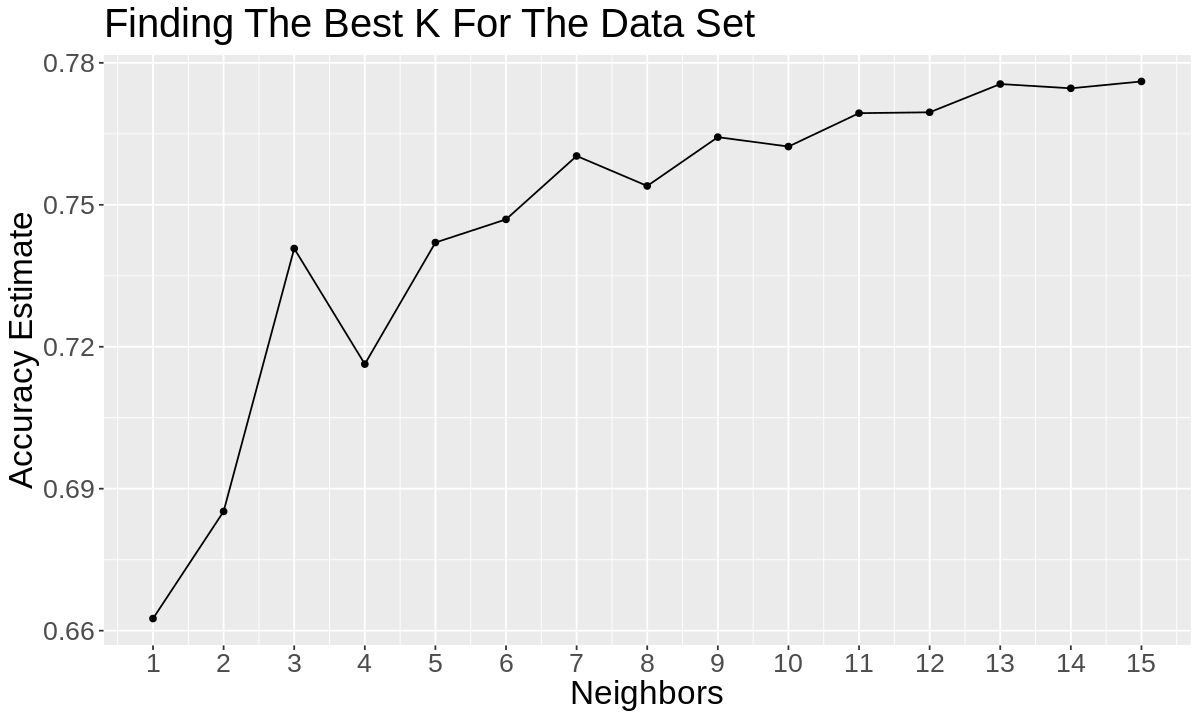

In [9]:
set.seed(1234)
accuracies <- credit_fit %>% 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate", title = "Finding The Best K For The Data Set") +
      scale_x_continuous(breaks = seq(0, 20, by = 1)) +
        theme(text = element_text(size=20))
accuracy_versus_k

Figure 3: Finding The Best K For The Data Set. The graph shows that the K with the highest accuracy estimate is 15, which is the K we chose. Although we tuned with grid = 100, the K values only went up to 15. We asked a TA on how to fix this, but they didn't know so we stuck with the choice of K = 15.



<span style = "color:black; font-size:16px"> Following this, we took our new K value and built out our new model spec with the K value set to 15. We used the same recipe as before and then added the recipe and new model to a workflow and fit the training data. Next, we began predicting our test set with this final model and binded the columns so that we would be able to see the predicted class and the true class of the test data set. Next we made a confusion matrix which included the true classifier values as well as the predicted classifier values from our dataset. With these predictions we were able to predict the accuracy of our model which was 77.9%. </span>


In [10]:
set.seed(1234)
knn_final <- nearest_neighbor(weight_func = "rectangular", neighbors = 15) %>%
      set_engine("kknn") %>%
      set_mode("classification")
credit_final = workflow() %>%
      add_recipe(credit_recipe) %>%
      add_model(knn_final) %>%
      fit(data = credit_train)


In [11]:
set.seed(1234)
credit_predictions = predict(credit_final, credit_test) %>%
      bind_cols(credit_test)
credit_metrics <- credit_predictions %>%
        metrics(truth = default_payment_next_month, estimate = .pred_class) 
credit_conf_mat <- credit_predictions %>%
        conf_mat(truth = default_payment_next_month, estimate = .pred_class) 
credit_predictions
credit_metrics
credit_conf_mat

.pred_class,EDUCATION,AGE,default_payment_next_month
<fct>,<dbl>,<dbl>,<fct>
0,2,39,1
0,3,30,1
0,1,35,0
⋮,⋮,⋮,⋮
0,2,32,0
0,2,35,1
0,1,34,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7794677
kap,binary,0.0000000


          Truth
Prediction    0    1
         0 1435  406
         1    0    0

Table 6: The prediction, metrics, and confustion matrix's results on the testing set, producing an accuracy of about 78%.

In [12]:
accuracy <- slice(credit_metrics, 1) %>% pull(3)
accuracy

[1] 0.7794677

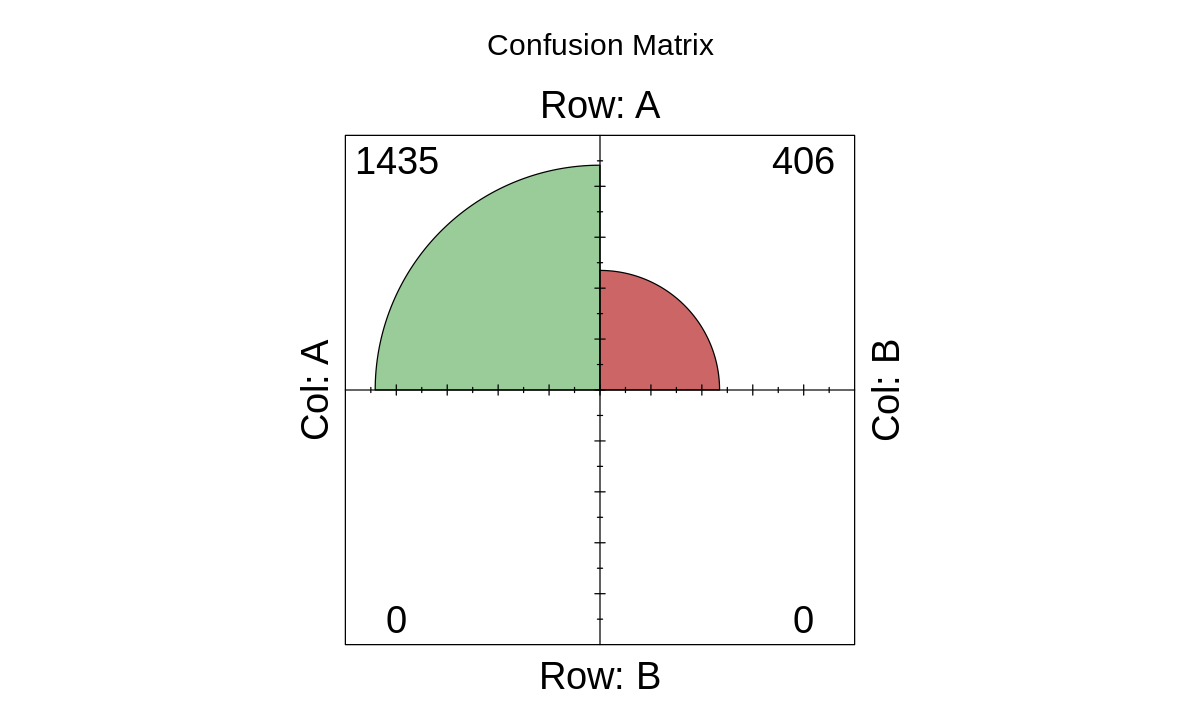

In [13]:
ctable <- as.table(matrix(c(1435, 406, 0, 0), nrow = 2, byrow = TRUE))
fourfoldplot(ctable, color = c("#CC6666", "#99CC99"),
             conf.level = 0, margin = 1, main = "Confusion Matrix")

Figure 4: Confusion Matrix Graph. This graph shows the finding of our confusion matrix, which proportionally shows correctly classified vs incorrectly classified.

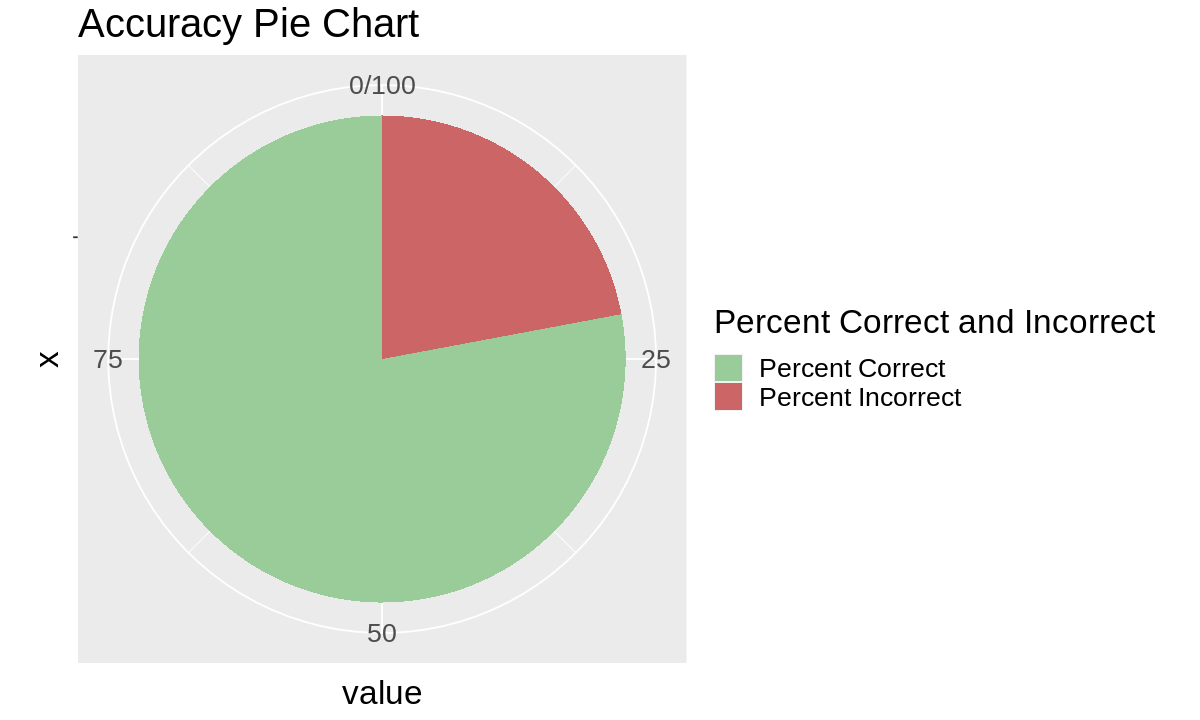

In [14]:
df <- data.frame(
  group = c("Percent Correct", "Percent Incorrect"),
  value = c(accuracy * 100, 100 - (accuracy * 100))
  )
bp<- ggplot(df, aes(x="", y=value, fill=group))+
geom_bar(width = 1, stat = "identity") +
ggtitle("Accuracy Pie Chart") +
labs(fill = "Percent Correct and Incorrect")

pie <- bp + coord_polar("y", start=0)
pie <- pie + scale_fill_manual(values=c("#99CC99", "#CC6666")) + theme(text = element_text(size=20))
pie

Figure 5: Summary Pie Chart Of Our Finding. This pie chart summarizes the accuracy of our findings, which is correct about 78% of the time.

<span style="color:blue; font-size:18px; font-weight:bold">Part 3: Discussion: </span>

<span style = "color:black; font-size:16px"> Our final accuracy from our tuned model was 77.9%. From the final graphs that we plotted, we found that our classification analysis had a fairly high accuracy with the predictor values that we chose. Although the accuracy is fairly high, there is most definitely room for improvement. If you reference the pie chart, on average, our model correctly predicts the likelihood of credit card default approximately 3 out 4 times. With this fairly high accuracy, it is safe to say that the education level an individual has and their age does play a role in their likelihood to default. </span>

<span style = "color:black; font-size:16px"> The accuracy we achieved from our model exceeded what was predicted; as stated in our introduction, we thought that the model would be about 70% accurate, however, it was closer to a 77.9% accuracy rate. Since the accuracy was higher than 50% (based on randomly selecting credit risk), it can be confidently stated that there is a correlation between an individual’s education and age, and their credit default risk.  </span>

<span style = "color:black; font-size:16px"> The impact of the findings within this report are of great consequence to the financial industry. Given that our model was able to predict credit card default fairly accurately, banks and other financial institutions can both use our model, and build on it to improve it, to further mitigate their risk. As lending money to individuals has its inherent risk, it is absolutely imperative that these financial institutions mitigate as much risk as possible to ensure secure cash flows and revenue from their credit card business.  </span>

<span style = "color:black; font-size:16px"> Due to the onset of COVID-19, the economic realities are much different than in 2016, the year in which the data set was donated. Due to this, a potential further question that would be very interesting to investigate is if the created model is still relevant today? Since unemployment rates at the height of lockdowns was about 4.1%, the highest it has been in over 6 years (Reuters, 2020). While we have not shown that credit card default and unemployment are correlated, the two variables have been linked in other articles (Bai, 2016). As such, investigating if the model holds in times of economic depression would be a question to investigate in the future. </span>
    
<span style = "color:black; font-size:16px"> However, one of the questions that we feel is most critical in investigating is whether or not using predictive modelling to determine the risk of an individual in defaulting is ethical. The availability of credit has been linked to increased economic output, and the ability to achieve a higher quality of life (Proctor & Anand, 2017, 322-346). As such, if the predictive model is not entirely accurate or has inherent biases present (such as giving different risk scores for different races, sex, etc.), it could lead to a negative feedback loop for individuals already experiencing economic hardship with no escape from poverty through credit. As such, more research needs to be conducted into the ethical realities of using a model to judge a person’s credit risk.</span>

<span style="color:blue; font-size:18px; font-weight:bold"> Part 4: References </span>

<span style = "color:black; font-size:16px"> Alam, Talha Mahboob, et al. “An Investigation of Credit Card Default Prediction in the Imbalanced Datasets.” IEEE Xplore, IEEE, 26 Oct. 2020, ieeexplore.ieee.org/document/9239944?fbclid=IwAR3zMjKdc4EdLV5A4r5RRW_BFy1VnOY9QQewm8qRdsYTlPFBCMurTpU6DA0. </span>

<span style = "color:black; font-size:16px"> Bai, H. (2016). Unemployment and Credit Risk. Supply and Demand eJournal. https://www.semanticscholar.org/paper/Unemployment-and-Credit-Risk-Bai/375a7d56701fe8ec018feb308669e7baa9322cbd#paper-header CEIC. (2018, May). Taiwan: Credit CARD STATISTICS: CEIC. Retrieved March 12, 2021, from https://www.ceicdata.com/en/taiwan/credit-card-statistics </span>

<span style = "color:black; font-size:16px"> Proctor, J., & Anand, P. (2017, September 6). Is credit associated with a higher quality of life? A capability approach. Progress in Development Studies, 17(4), 322 - 346. https://journals-sagepub-com.ezproxy.library.ubc.ca/doi/full/10.1177/1464993417716359?utm_source=summon&utm_medium=discovery-provider </span>

<span style = "color:black; font-size:16px"> Reuters Staff. (2020, May 22). Taiwan jobless rate spikes to six year high on virus impact. Reuters. https://www.reuters.com/article/healthcoronavirus-taiwan-unemployment-idUSL4N2C90Z4 </span>